In [32]:
import copy
import math
import time
import pickle
import struct

import numpy as np                  # 矩阵
import matplotlib.pyplot as plt     # 绘图

from numba import njit              # 加速 cpu
from numba import cuda              # 加速 gpu(cuda)
from pathlib import Path            # 处理路径

from Activation import Activation
from ProgressBar import ProgressBar 

In [33]:
def bypass(x):
    return x
def tanh(x):
    return np.tanh(x)
def softmax(x):
    exp=np.exp(x - x.max())
    return exp / exp.sum()

def d_softmax(data):
    sm = softmax(data)
    return np.diag(sm) - np.outer(sm,sm)

def d_tanh(data):
    return 1 / ((np.cosh(data)) ** 2)

def d_bypass(x):
    return 1

differential = {softmax:d_softmax, tanh:d_tanh, bypass:d_bypass}
d_type = {bypass:'times', softmax:'dot', tanh:'times'} # tanh 和 bypass都进行了优化而 softmax没有优化

In [34]:
dimensions = [28*28, 100, 10]
activation = [bypass, tanh, softmax]
distribution = [
    {}, # leave it empty !
    {'b':[0, 0],'w':[-math.sqrt(6 / (dimensions[0] + dimensions[1])), math.sqrt(6 / (dimensions[0] + dimensions[1]))]},
    {'b':[0, 0],'w':[-math.sqrt(6 / (dimensions[1] + dimensions[2])), math.sqrt(6 / (dimensions[1] + dimensions[2]))]},
]

In [35]:
def init_parameters_b(layer):
    dist=distribution[layer]['b']
    return np.random.rand(dimensions[layer])*(dist[1]-dist[0])+dist[0]
def init_parameters_w(layer):
    dist=distribution[layer]['w']
    return np.random.rand(dimensions[layer-1],dimensions[layer])*(dist[1]-dist[0])+dist[0]
def init_parameters():
    parameter = []
    for i in range(len(distribution)):
        layer_parameter = {}
        for j in distribution[i].keys():
            if j == 'b':
                layer_parameter['b'] = init_parameters_b(i)
                continue
            if j == 'w':
                layer_parameter['w'] = init_parameters_w(i)
                continue
        parameter.append(layer_parameter)
    return parameter

In [36]:
def predict(img,parameters):
    l_in = img
    l_out = activation[0](l_in)
    for layer in range(1, len(dimensions)):
        l_in = np.dot(l_out,parameters[layer]['w']) + parameters[layer]['b']
        l_out = activation[layer](l_in)
    return l_out


In [37]:
dataset_path = Path('./MNIST')
train_img_path = dataset_path / 'train-images.idx3-ubyte'
train_lab_path = dataset_path / 'train-labels.idx1-ubyte'
test_img_path = dataset_path / 't10k-images.idx3-ubyte'
test_lab_path = dataset_path / 't10k-labels.idx1-ubyte'
train_num=50000
valid_num=10000
test_num=10000

with open(train_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    tmp_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)/255
    train_img=tmp_img[:train_num]
    valid_img=tmp_img[train_num:]
    
with open(test_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    test_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)/255

with open(train_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    tmp_lab=np.fromfile(f,dtype=np.uint8)
    train_lab=tmp_lab[:train_num]
    valid_lab=tmp_lab[train_num:]
    
with open(test_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    test_lab=np.fromfile(f,dtype=np.uint8)

In [38]:
def show_train(index):
    plt.imshow(train_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(train_lab[index]))
def show_valid(index):
    plt.imshow(valid_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(valid_lab[index]))
def show_test(index):
    plt.imshow(test_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(test_lab[index]))

In [39]:
h=0.001
func=softmax
input_len=4
for i in range(input_len):
    test_input=np.random.rand(input_len)
    derivative=differential[func](test_input)
    value1=func(test_input)
    test_input[i]+=h
    value2=func(test_input)
#     print((value2-value1)/h)
#     print(derivative[i])
    print(derivative[i]-(value2-value1)/h)

[-4.44642113e-05  1.31054825e-05  1.16053365e-05  1.97533922e-05]
[ 1.99645700e-05 -4.80940363e-05  1.47914392e-05  1.33380272e-05]
[ 1.19877075e-05  1.48912282e-05 -4.73123230e-05  2.04333872e-05]
[ 1.58115703e-05  1.17123885e-05  1.57793249e-05 -4.33032837e-05]


In [40]:
h=0.0001
func=tanh
input_len=4
for i in range(input_len):
    test_input=np.random.rand(input_len)
    derivative=differential[func](test_input)
    value1=func(test_input)
    test_input[i]+=h
    value2=func(test_input)
#     print((value2-value1)/h)
#     print(derivative[i])
    print(derivative[i]-((value2-value1)/h)[i])

3.799985560259955e-05
1.0110819491426781e-05
3.83452982636312e-05
2.9673263405416428e-05


In [41]:
onehot = np.identity(dimensions[-1])
print(onehot)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [42]:
def sqr_loss(img, lab, parameters):
    y_pred = predict(img, parameters)
    y = onehot[lab]
    diff = y - y_pred
    return np.dot(diff, diff)

$\frac{d}{dx}f_1(f_2(f_3(.....f_n())))=$

In [43]:
# 计算梯度
def grad_parameters(img, lab,parameters):
    # 第一层
    l_in_list = [img]
    l_out_list = [activation[0](l_in_list[0])]
    # 把网络上所有的输入输出存下俩
    for layer in range(1, len(dimensions)):
        l_in = np.dot(l_out_list[layer - 1], parameters[layer]['w']) + parameters[layer]['b']
        l_out = activation[layer](l_in)
        l_in_list.append(l_in)
        l_out_list.append(l_out)
    
    d_layer = -2 * (onehot[lab] - l_out_list[-1])
    
    grad_result = [None] * len(dimensions)
    for layer in range(len(dimensions)-1, 0, -1):
        if d_type[activation[layer]] == 'times':
            d_layer = differential[activation[layer]](l_in_list[layer]) * d_layer
        if d_type[activation[layer]] == 'dot':
            d_layer = np.dot(differential[activation[layer]](l_in_list[layer]), d_layer)
        grad_result[layer] = {}
        grad_result[layer]['b'] = d_layer
        grad_result[layer]['w'] = np.outer(l_out_list[layer - 1], d_layer)
        d_layer=np.dot(parameters[layer]['w'], d_layer)
    
    return grad_result

In [44]:
parameters=init_parameters()

In [45]:
h=0.00001
layer=2
pname='b'
grad_list=[]
for i in range(len(parameters[layer][pname])):
    img_i=np.random.randint(train_num)
    test_parameters=init_parameters()
    derivative=grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)[layer][pname]
    value1=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
    test_parameters[layer][pname][i]+=h
    value2=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
    grad_list.append(derivative[i]-(value2-value1)/h)
np.abs(grad_list).max()

3.7686415523680017e-07

In [46]:
h=0.00001
layer=1
pname='b'
grad_list=[]
for i in range(len(parameters[layer][pname])):
    img_i=np.random.randint(train_num)
    test_parameters=init_parameters()
    derivative=grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)[layer][pname]
    value1=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
    test_parameters[layer][pname][i]+=h
    value2=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
    grad_list.append(derivative[i]-(value2-value1)/h)
np.abs(grad_list).max()

2.661868855266536e-07

In [47]:
h=0.001
layer=2
pname='w'
grad_list=[]
for i in range(len(parameters[layer][pname])):
    for j in range(len(parameters[layer][pname][0])):
        img_i=np.random.randint(train_num)
        test_parameters=init_parameters()
        derivative=grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)[layer][pname]
        value1=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
        test_parameters[layer][pname][i][j]+=h
        value2=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
        grad_list.append(derivative[i][j]-(value2-value1)/h)
np.abs(grad_list).max()

4.260777898246193e-05

In [48]:
# h=0.00001
# layer=1
# pname='w'
# grad_list=[]
# for i in range(len(parameters[layer][pname])):
#     for j in range(len(parameters[layer][pname][0])):
#         img_i=np.random.randint(train_num)
#         test_parameters=init_parameters()
#         derivative=grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)[layer][pname]
#         value1=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
#         test_parameters[layer][pname][i][j]+=h
#         value2=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
#         grad_list.append(derivative[i][j]-(value2-value1)/h)
# np.abs(grad_list).max()

In [99]:
def valid_loss(parameters):
    loss_accu=0
    for img_i in range(valid_num):
        loss_accu+=sqr_loss(valid_img[img_i],valid_lab[img_i],parameters)
    return loss_accu/(valid_num/10000)
def valid_accuracy(parameters):
    correct=[predict(valid_img[img_i],parameters).argmax()==valid_lab[img_i] for img_i in range(valid_num)]
    return correct.count(True)/len(correct)
def train_loss(parameters):
    loss_accu=0
    for img_i in range(train_num):
        loss_accu+=sqr_loss(train_img[img_i],train_lab[img_i],parameters)
    return loss_accu/(train_num/10000)
def train_accuracy(parameters):
    correct=[predict(train_img[img_i],parameters).argmax()==train_lab[img_i] for img_i in range(train_num)]
    return correct.count(True)/len(correct)
def test_accuracy(parameters):
    correct=[predict(test_img[img_i],parameters).argmax()==test_lab[img_i] for img_i in range(test_num)]
    return correct.count(True)/len(correct)

In [50]:
def grad_add(grad1, grad2):
    for layer in range(1, len(grad1)):
        for pname in grad1[layer].keys():
            grad1[layer][pname] += grad2[layer][pname]
    return grad1
def grad_divide(grad, denominator):
    for layer in range(1, len(grad)):
        for pname in grad[layer].keys():
            grad[layer][pname] /= denominator
    return grad

def combine_parameters(parameters,grad,learn_rate):
    parameter_tmp=copy.deepcopy(parameters)
    for layer in range(1,len(parameter_tmp)):
        for pname in parameter_tmp[layer].keys():
            parameter_tmp[layer][pname]-=learn_rate*grad[layer][pname]
    return parameter_tmp

In [51]:
batch_size=100
def train_batch(current_batch,parameters):
    grad_accu=grad_parameters(train_img[current_batch*batch_size+0],train_lab[current_batch*batch_size+0],parameters)
    for img_i in range(1,batch_size):
        grad_tmp=grad_parameters(train_img[current_batch*batch_size+img_i],train_lab[current_batch*batch_size+img_i],parameters)
        grad_add(grad_accu, grad_tmp)
    grad_divide(grad_accu, batch_size)
    return grad_accu

In [52]:
parameters = init_parameters()
current_epoch = 0
train_loss_list = []
valid_loss_list = []
train_accu_list = []
valid_accu_list = []

In [53]:
print("训练集的正确率: {:.5f}".format(train_accuracy(parameters))) # 训练之后的正确率
print("验证集的正确率: {:.5f}".format(valid_accuracy(parameters))) # 训练之后的正确率
print("测试集的正确率: {:.5f}".format(test_accuracy(parameters)))  # 训练之后的正确率

训练集的正确率: 0.09574
验证集的正确率: 0.09210
测试集的正确率: 0.08690


In [55]:
learn_rate = 1 
epoch_num = 1
total_steps = train_num // batch_size * epoch_num
progress_bar = ProgressBar(total_steps)
for epoch in range(epoch_num):
    for i in range(train_num//batch_size):
        progress_bar.update(epoch * (train_num // batch_size) + i + 1)
        grad_tmp = train_batch(i, parameters)
        parameters = combine_parameters(parameters, grad_tmp, learn_rate)
    current_epoch += 1
    train_loss_list.append(train_loss(parameters))
    train_accu_list.append(train_accuracy(parameters))
    valid_loss_list.append(valid_loss(parameters))
    valid_accu_list.append(valid_accuracy(parameters))

[████████████████████████████████████████████████████████████] 100.0% Complete

In [56]:
print("训练集的正确率: {:.5f}".format(train_accuracy(parameters))) # 训练之后的正确率
print("验证集的正确率: {:.5f}".format(valid_accuracy(parameters))) # 训练之后的正确率
print("测试集的正确率: {:.5f}".format(test_accuracy(parameters)))  # 训练之后的正确率

训练集的正确率: 0.93166
验证集的正确率: 0.93650
测试集的正确率: 0.93280


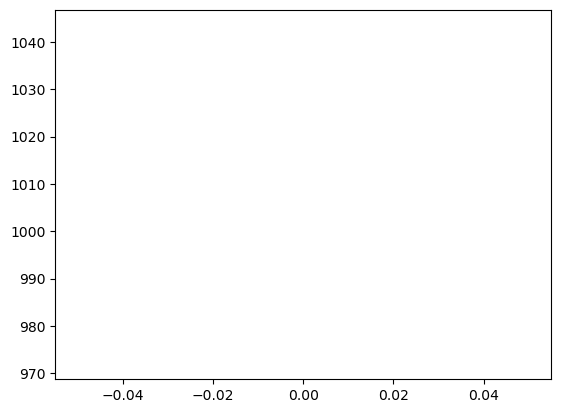

In [58]:
lower = -5
plt.plot(valid_loss_list[lower:], color='black', label='validation loss')
plt.plot(train_loss_list[lower:], color='red', label='train loss')
plt.show()

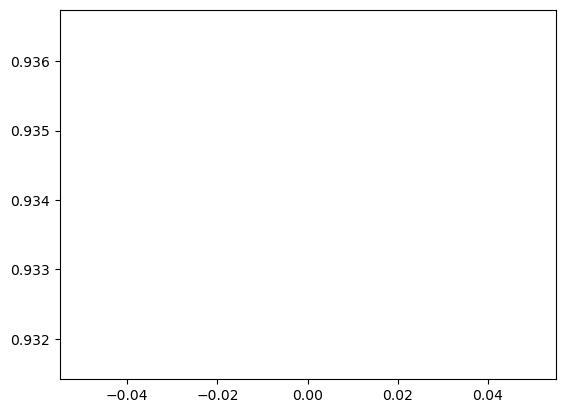

In [59]:
plt.plot(valid_accu_list[lower:], color='black', label='validation accuracy')
plt.plot(train_accu_list[lower:], color='red', label='train accuracy')
plt.show()

In [60]:
rand_batch = np.random.randint(train_num // batch_size) # 随机取一个训练集
grad_lr = train_batch(rand_batch, parameters) # 目前的梯度
lr_list = []
lower = -0.5
upper = 0.5
step = 0.1
progress_bar = ProgressBar(int((upper - lower) / step + 1))
for i, lr_pow in enumerate(np.linspace(lower, upper, num = int((upper - lower) / step + 1))):
    progress_bar.update(i)
    learn_rate = 10 ** lr_pow
    parameters_tmp = combine_parameters(parameters, grad_lr, learn_rate)
    train_loss_tmp = train_loss(parameters_tmp)
    lr_list.append([lr_pow, train_loss_tmp])
progress_bar.update(int((upper - lower) / step + 1))

[                                                            ] 0.0% Progress

KeyboardInterrupt: 

In [ ]:
lr_list

In [109]:
upper=len(lr_list) # 寻找学习率最合适的点(谷底也就是训练损失最低的点)
plt.plot(np.array(lr_list)[:upper, 0], np.array(lr_list)[:upper,1], color='black')
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [114]:
print(parameters[1]['b'].shape)
print(parameters[1]['w'].shape)
print(parameters[2]['b'].shape)
print(parameters[2]['w'].shape)
np.savetxt('p_1_b.txt', parameters[1]['b'], fmt = "%.5f")
np.savetxt('p_1_w.txt', parameters[1]['w'], fmt = "%.5f")
np.savetxt('p_2_b.txt', parameters[2]['b'], fmt = "%.5f")
np.savetxt('p_2_w.txt', parameters[2]['w'], fmt = "%.5f")

(100,)
(784, 100)
(10,)
(100, 10)


In [111]:
parameters_save = init_parameters()

In [115]:
b1 = np.loadtxt('./p_1_b.txt', dtype=np.float32).reshape(100,)
w1 = np.loadtxt('./p_1_w.txt', dtype=np.float32).reshape(784, 100)
b2 = np.loadtxt('./p_2_b.txt', dtype=np.float32).reshape(10,)
w2 = np.loadtxt('./p_2_w.txt', dtype=np.float32).reshape(100, 10)

parameters_save = {
    1: {'b': b1, 'w': w1},
    2: {'b': b2, 'w': w2}
}

In [116]:
print(test_accuracy(parameters_save))

0.9328
